In [ ]:
#This is based on:
# https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8759878
#codebase is from:
# https://www.kaggle.com/code/christianlillelund/classify-mnist-audio-using-spectrograms-keras-cnn/notebook

In [16]:
import csv
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import scipy as sp
import tensorflow as tf
import os

In [39]:
#load a testsample
data = sio.loadmat('training/'+'train_ecg_00092'+'.mat')
signal = data['val'].T
print(signal.shape)
signal = np.ravel(signal)
print(signal.shape)
#plt.plot(signal) 
#plt.show()

(9000, 1)
(9000,)


In [40]:
fs = 300

The start and end index are:  900 8100
The new length of the signal is:  7200


<function matplotlib.pyplot.show(close=None, block=None)>

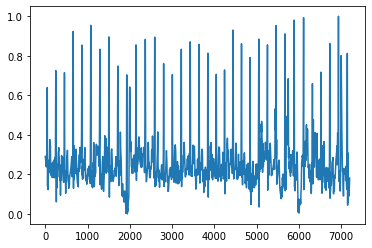

In [41]:
#cutoff the first and last 3 seconds of the signal
startindex = fs * 3 #seconds
endindex = signal.size - startindex
print("The start and end index are: ",startindex, endindex)
cutsignal = signal[startindex:endindex]
print("The new length of the signal is: ",cutsignal.size)

#normalise signalvalues
normalisesignal = (cutsignal - np.min(cutsignal)) / (np.max(cutsignal) - np.min(cutsignal))

#plot the cut and normalised signal
plt.plot(normalisesignal)
plt.show

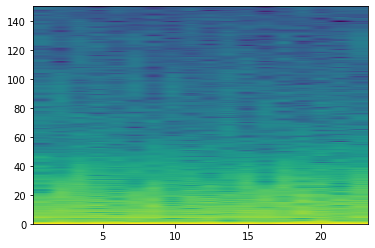

In [42]:
#create spectogram of signal
spectrum, freqs, t, im = plt.specgram(normalisesignal, NFFT=512, Fs=300)
spectrum.shape
plt.savefig('testfig.png')

In [46]:
with open('training/REFERENCE.csv') as csv_file:      # Einlesen der Liste mit Dateinamen und Zuordnung
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        data = sio.loadmat('training/'+row[0]+'.mat')   # Import der EKG-Dateien
        signal = data['val'].T
        signal = np.ravel(signal)
        startindex = fs * 3 #seconds
        endindex = signal.size - startindex
        cutsignal = signal[startindex:endindex]
        normalisesignal = (cutsignal - np.min(cutsignal)) / (np.max(cutsignal) - np.min(cutsignal))
        spectrum, freqs, t, im = plt.specgram(normalisesignal, NFFT=512, Fs=300)
        
        if row[1]=='N':
            plt.savefig('Preproces/N/'+row[0]+'_spectrum.png')         # Zuordnung zu "Normal"
       
        if row[1]=='A':
            plt.savefig('Preproces/A/'+row[0]+'_spectrum.png')             # Zuordnung zu "Vorhofflimmern"
        
        del data, signal, cutsignal, normalisesignal, spectrum, freqs,t, im
        plt.close()
        
        line_count = line_count + 1
        if (line_count % 100)==0:
            print(str(line_count) + "\t Dateien wurden verarbeitet.")

100	 Dateien wurden verarbeitet.
200	 Dateien wurden verarbeitet.
300	 Dateien wurden verarbeitet.
400	 Dateien wurden verarbeitet.
500	 Dateien wurden verarbeitet.
600	 Dateien wurden verarbeitet.
700	 Dateien wurden verarbeitet.
800	 Dateien wurden verarbeitet.
900	 Dateien wurden verarbeitet.
1000	 Dateien wurden verarbeitet.
1100	 Dateien wurden verarbeitet.
1200	 Dateien wurden verarbeitet.
1300	 Dateien wurden verarbeitet.
1400	 Dateien wurden verarbeitet.
1500	 Dateien wurden verarbeitet.
1600	 Dateien wurden verarbeitet.
1700	 Dateien wurden verarbeitet.
1800	 Dateien wurden verarbeitet.
1900	 Dateien wurden verarbeitet.
2000	 Dateien wurden verarbeitet.
2100	 Dateien wurden verarbeitet.
2200	 Dateien wurden verarbeitet.
2300	 Dateien wurden verarbeitet.
2400	 Dateien wurden verarbeitet.
2500	 Dateien wurden verarbeitet.
2600	 Dateien wurden verarbeitet.
2700	 Dateien wurden verarbeitet.
2800	 Dateien wurden verarbeitet.
2900	 Dateien wurden verarbeitet.
3000	 Dateien wurden ve

In [89]:
# Declare constants
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 2

In [84]:
# Make a dataset containing the training spectrograms
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory='Preproces',
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=0)

# Make a dataset containing the validation spectrogram
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory='Preproces',
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=0)

Found 4102 files belonging to 2 classes.
Using 3282 files for training.
Found 4102 files belonging to 2 classes.
Using 820 files for validation.


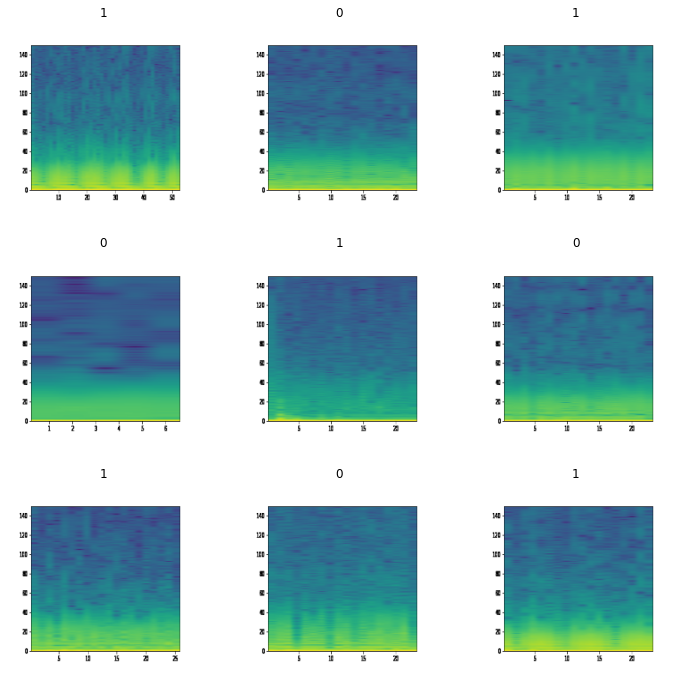

In [86]:
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.show()

In [87]:
# Function to prepare our datasets for modelling
def prepare(ds, augment=False):
    # Define our one transformation
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    flip_and_rotate = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ])
    
    # Apply rescale to both datasets and augmentation only to training
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    if augment: ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds

train_dataset = prepare(train_dataset, augment=False)
valid_dataset = prepare(valid_dataset, augment=False)

In [90]:
# Create CNN model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)

# Train model for 10 epochs, capture the history
history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset)

Epoch 1/10
103/103 [==============================] - 199s 2s/step - loss: 0.5394 - accuracy: 0.7718 - val_loss: 2.4210 - val_accuracy: 0.1159
Epoch 2/10
103/103 [==============================] - 202s 2s/step - loss: 0.3825 - accuracy: 0.8678 - val_loss: 0.3956 - val_accuracy: 0.8841
Epoch 3/10
103/103 [==============================] - 216s 2s/step - loss: 0.3392 - accuracy: 0.8824 - val_loss: 0.4780 - val_accuracy: 0.8841
Epoch 4/10
103/103 [==============================] - 216s 2s/step - loss: 0.3042 - accuracy: 0.8952 - val_loss: 0.5378 - val_accuracy: 0.8841
Epoch 5/10
103/103 [==============================] - 196s 2s/step - loss: 0.2826 - accuracy: 0.8955 - val_loss: 0.8743 - val_accuracy: 0.8841
Epoch 6/10
103/103 [==============================] - 215s 2s/step - loss: 0.2651 - accuracy: 0.9055 - val_loss: 0.3954 - val_accuracy: 0.8854
Epoch 7/10
103/103 [==============================] - 227s 2s/step - loss: 0.2118 - accuracy: 0.9190 - val_loss: 2.6891 - val_accuracy: 0.1159

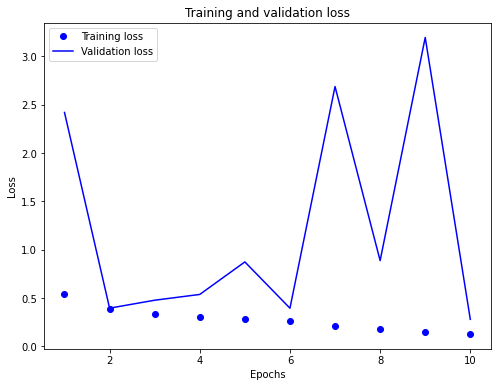

In [91]:
# Plot the loss curves for training and validation.
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

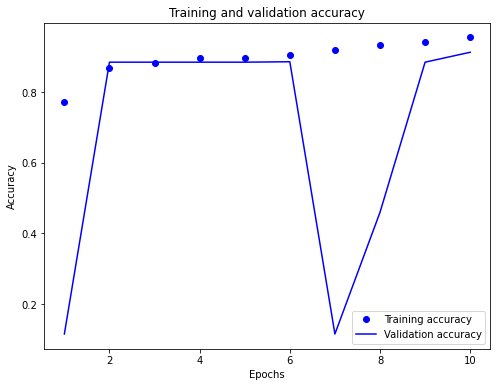

In [92]:
# Plot the accuracy curves for training and validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()